In [1]:
# Allow the PyMC3 models to be imported in the notebook folder

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
from pymc3 import summary, traceplot
import pymc3 as pm

import theano
import theano.tensor as T

%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (15, 10)

plt.rcParams['font.size'] = 16

In [4]:
from pymc3_models.models.HierarchicalLogisticRegression import HierarchicalLogisticRegression

In [5]:
num_pred = 2
num_samples = 700000
num_categories = 2

In [6]:
alphas = 5 * np.random.randn(num_categories) + 5 # mu_alpha = sigma_alpha = 5
betas = 10 * np.random.randn(num_categories, num_pred) + 10 # mu_beta = sigma_beta = 10

In [7]:
alphas

array([ 22.64839575,   1.83569885])

In [8]:
betas

array([[  1.98412394e+01,   3.87807425e-03],
       [ -4.10259233e+00,   1.57742792e+01]])

In [9]:
def numpy_invlogit(x):
    return 1 / (1 + np.exp(-x))

In [10]:
x_a = np.random.randn(num_samples, num_pred)
y_a = np.random.binomial(1, numpy_invlogit(alphas[0] + np.sum(betas[0] * x_a, 1)))
x_b = np.random.randn(num_samples, num_pred)
y_b = np.random.binomial(1, numpy_invlogit(alphas[1] + np.sum(betas[1] * x_b, 1)))

X = np.concatenate([x_a, x_b])
Y = np.concatenate([y_a, y_b])
cats = np.concatenate([
    np.zeros(num_samples, dtype=np.int),
    np.ones(num_samples, dtype=np.int)
])

Fit w/ ADVI
===

In [11]:
HLM1 = HierarchicalLogisticRegression()

In [12]:
HLM1.fit(X, Y, cats, minibatch_size=2000, inference_args={'n': 60000})

Average Loss = 164.88: 100%|██████████| 60000/60000 [02:01<00:00, 493.07it/s]
Finished [100%]: Average Loss = 164.83


HierarchicalLogisticRegression()

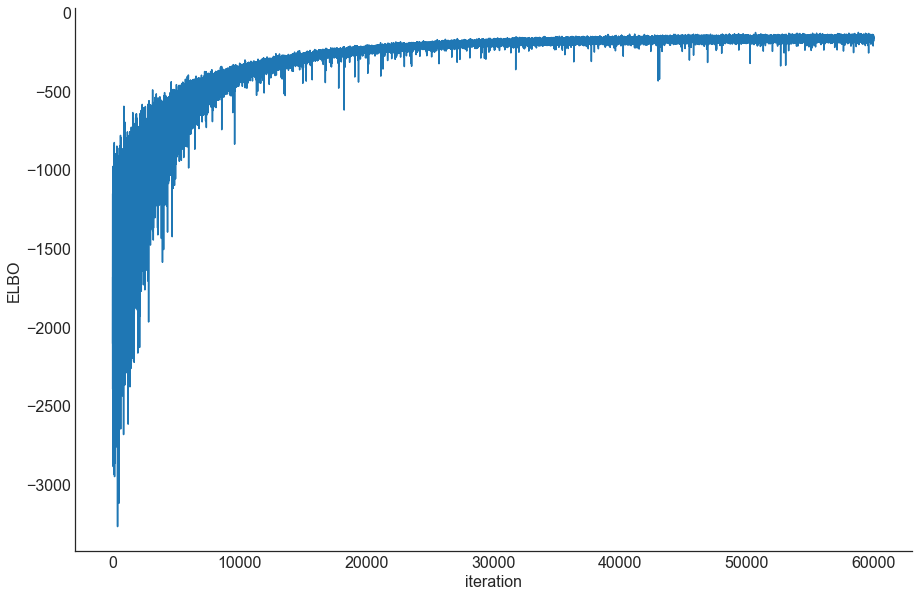

In [13]:
HLM1.plot_elbo()

In [14]:
summary(HLM1.trace[1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu_alpha,3.588359,5.817148,0.064736,-7.619917,15.097593
mu_beta,3.692959,4.433254,0.044723,-5.174900,12.319579
alpha__0,9.287155,0.212951,0.002472,8.879906,9.711693
alpha__1,1.561967,0.207871,0.002258,1.161751,1.974611
beta__0_0,8.037437,0.197976,0.002178,7.645411,8.418766
beta__0_1,0.001692,0.219021,0.002198,-0.445680,0.418524
beta__1_0,-3.477180,0.212767,0.002253,-3.872841,-3.026590
beta__1_1,13.451196,0.677413,0.007307,12.127521,14.772437
sigma_alpha,20.230039,21.342934,0.264676,0.927584,57.589782
sigma_beta,11.757021,6.033392,0.066120,2.768625,23.631694


In [15]:
alphas

array([ 22.64839575,   1.83569885])

In [16]:
betas

array([[  1.98412394e+01,   3.87807425e-03],
       [ -4.10259233e+00,   1.57742792e+01]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13c9ff320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13b719ac8>]], dtype=object)

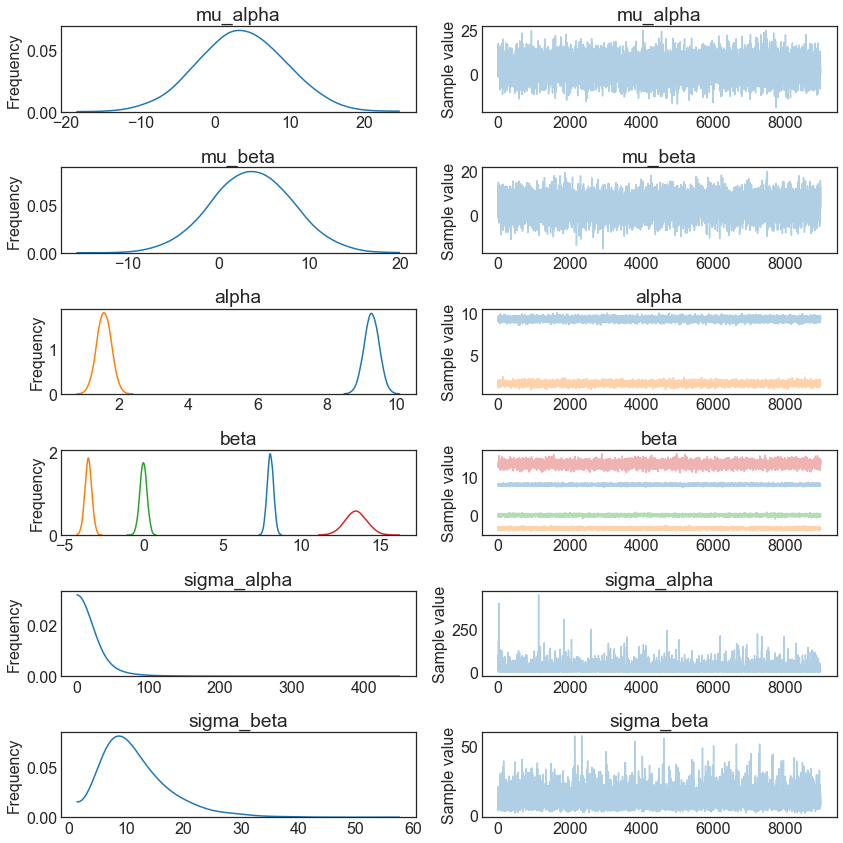

In [17]:
traceplot(HLM1.trace[1000:])

In [18]:
#probs = HLM1.predict_proba(X, cats)

In [19]:
#pred = HLM1.predict(X, cats)

In [20]:
HLM1.score(X, Y, cats)

100%|██████████| 2000/2000 [07:49<00:00,  4.26it/s]


0.97558714285714287

In [21]:
HLM1.save('pickle_jar/HLR_jar/')

In [22]:
HLM1.num_cats

2

In [23]:
HLM2 = HierarchicalLogisticRegression()

In [24]:
HLM2.load('pickle_jar/HLR_jar/')

In [25]:
HLM2.score(X, Y, cats)

100%|██████████| 2000/2000 [06:40<00:00,  4.99it/s]


0.97558999999999996

Fit w/ NUTS
===

In [ ]:
HLM3 = HierarchicalLogisticRegression()

In [ ]:
HLM3.fit(X, Y, cats, inference_type='nuts', inference_args={'draws': 2000})

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_beta_log__, mu_beta, sigma_alpha_log__, mu_alpha]
  8%|▊         | 188/2500 [28:26<5:49:44,  9.08s/it]

In [ ]:
traceplot(HLM3.trace[1000:])

In [ ]:
HLM3.score(X, Y, cats)